An Exploratory Kernel for the Porto Seguro Competition. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [2]:
df = pd.read_csv('../input/train.csv')
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## Regex and Data Wrangling

In order to isolate logically related features (i.e. ind, reg, car, calc), and discriminate among categorical, binary and continuous properties we need a bunch of regular expressions to filter key words in the column names.

In [3]:
import re
def istype(name,_type):
    match = re.search('^.*'+_type+'.*$',name)
    if match:
        return True
    else:
        return False
    
def notBinOrCat(name):
    match = re.search('^.*bin.*$',name)
    if match:
        return False
    else:
        match = re.search('^.*cat.*$',name)
        if match:
            return False
        else:
            return True

The following lists of column names may come in handy.

In [4]:
ind_cols = [col for col in df.columns if istype(col,'ind')]
reg_cols = [col for col in df.columns if istype(col,'reg')]
car_cols = [col for col in df.columns if istype(col,'car')]
calc_cols= [col for col in df.columns if istype(col,'calc')]

ind_cat = [col for col in ind_cols if istype(col,'cat')]
reg_cat = [col for col in reg_cols if istype(col,'cat')]
car_cat = [col for col in car_cols if istype(col,'cat')]
calc_cat= [col for col in calc_cols if istype(col,'cat')]

ind_bin = [col for col in ind_cols if istype(col,'bin')]
reg_bin = [col for col in reg_cols if istype(col,'bin')]
car_bin = [col for col in car_cols if istype(col,'bin')]
calc_bin= [col for col in calc_cols if istype(col,'bin')]

ind_con = [col for col in ind_cols if not (istype(col,'bin') or istype(col,'cat'))]
reg_con = [col for col in reg_cols if not (istype(col,'bin') or istype(col,'cat'))]
car_con = [col for col in car_cols if not (istype(col,'bin') or istype(col,'cat'))]
calc_con= [col for col in calc_cols if not (istype(col,'bin') or istype(col,'cat'))]



## Target

In [5]:
df['target'].unique()

array([0, 1])

There are FAR less ones than zeros

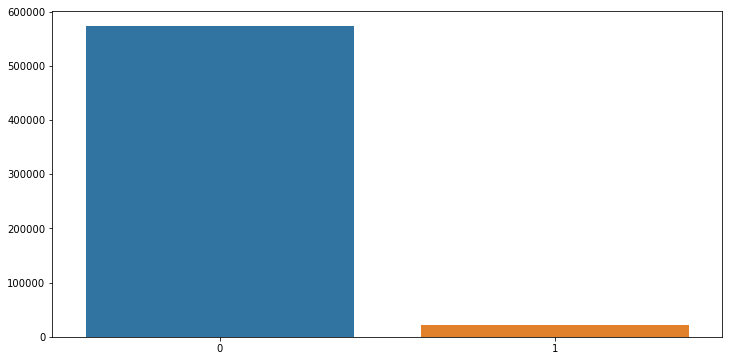

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
thist = df.groupby(['target'],as_index=False).count()['id']
fig,axarr = plt.subplots(1,1,figsize=(12,6))
sns.barplot(x=thist.index,y=thist.values)

I could be wrong but, in my opinion this is too much imbalanced.
See https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ for more information on possible problems related to imbalanced datasets.
Let's create a reduced datase. We use the sample function to randomly choose 25000 recordes having target 0.

Finally w use sample again to shuffle positives and negatives.

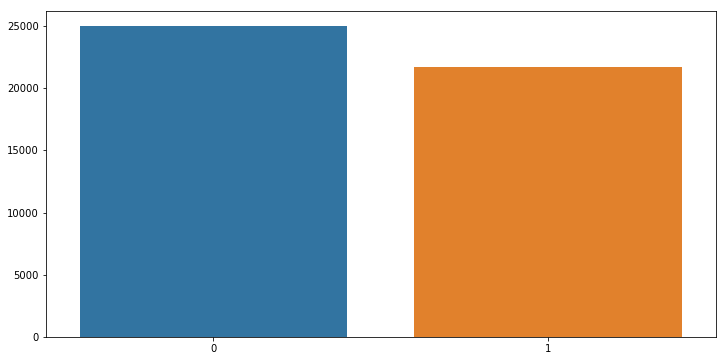

In [7]:
zeros = df[df['target']==0].sample(n=25000)
ones = df[df['target']==1]
rdf = pd.concat([zeros,ones],axis=0)

thist = rdf.groupby(['target'],as_index=False).count()['id']
fig,axarr = plt.subplots(1,1,figsize=(12,6))
sns.barplot(x=thist.index,y=thist.values)
rdf = rdf.sample(frac=1)
plt.show()

## Binary Features

Here is a nice histogram showing how many times each binary proerty occurs with 1 value in the dataset.

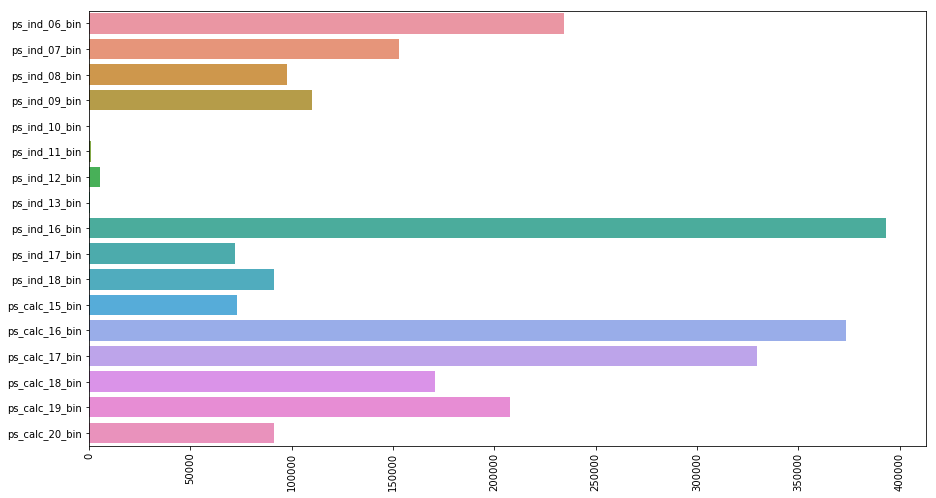

In [8]:
f,axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
ibh = df[ind_bin].sum()
cbh = df[calc_bin].sum()
bins = pd.concat([ibh,cbh],axis=0)
sns.barplot(x=bins.values,y=bins.index,orient='h')

Clusters of binary properties exhibit some kind of correlation.

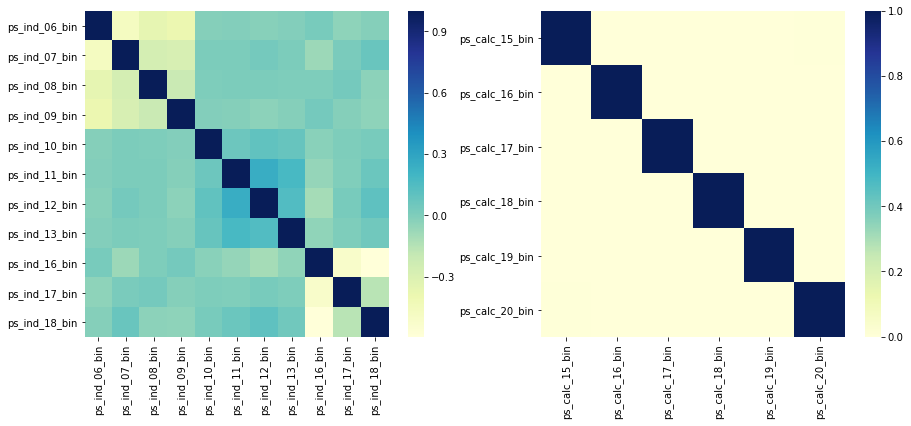

In [9]:
f,axarray = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation='vertical')
sns.heatmap(df[ind_bin].corr(),ax=axarray[0],cmap="YlGnBu")
sns.heatmap(df[calc_bin].corr(),ax=axarray[1],cmap="YlGnBu")


## Continuous

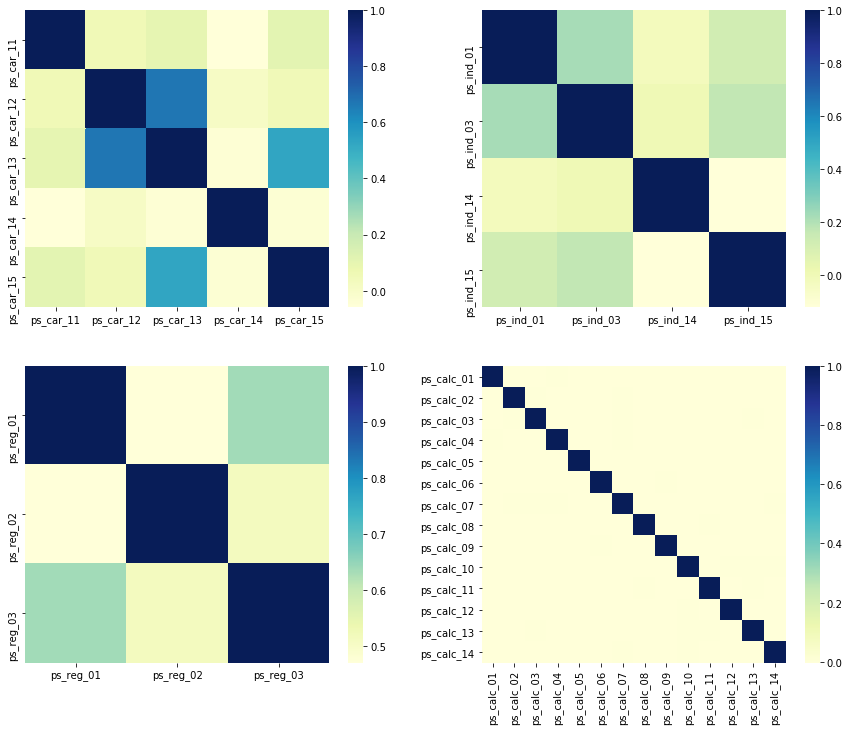

In [10]:
f,axarray = plt.subplots(2,2,figsize=(15,12))
plt.xticks(rotation='vertical')
sns.heatmap(df[car_con].corr(),ax=axarray[0][0],cmap="YlGnBu")
sns.heatmap(df[ind_con].corr(),ax=axarray[0][1],cmap="YlGnBu")
sns.heatmap(df[reg_con].corr(),ax=axarray[1][0],cmap="YlGnBu")
sns.heatmap(df[calc_con].corr(),ax=axarray[1][1],cmap="YlGnBu")
plt.show()

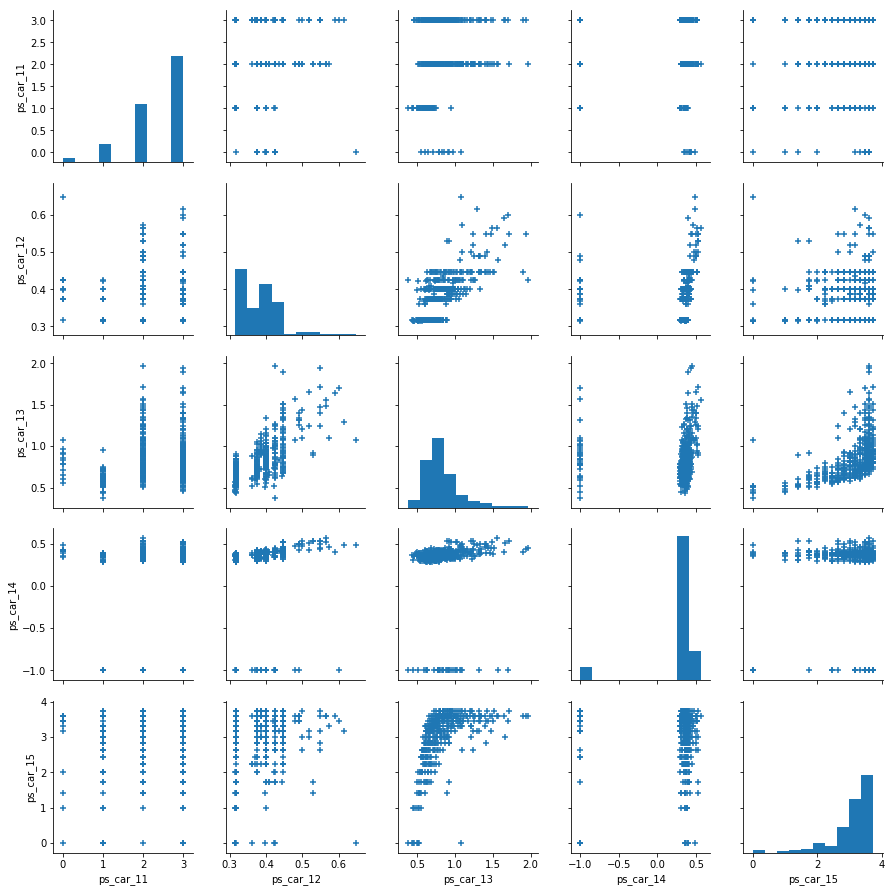

In [11]:
sns.pairplot(df[car_con][0:500],markers="+")

let's check how the target classes are distributd among the CAR continuous features

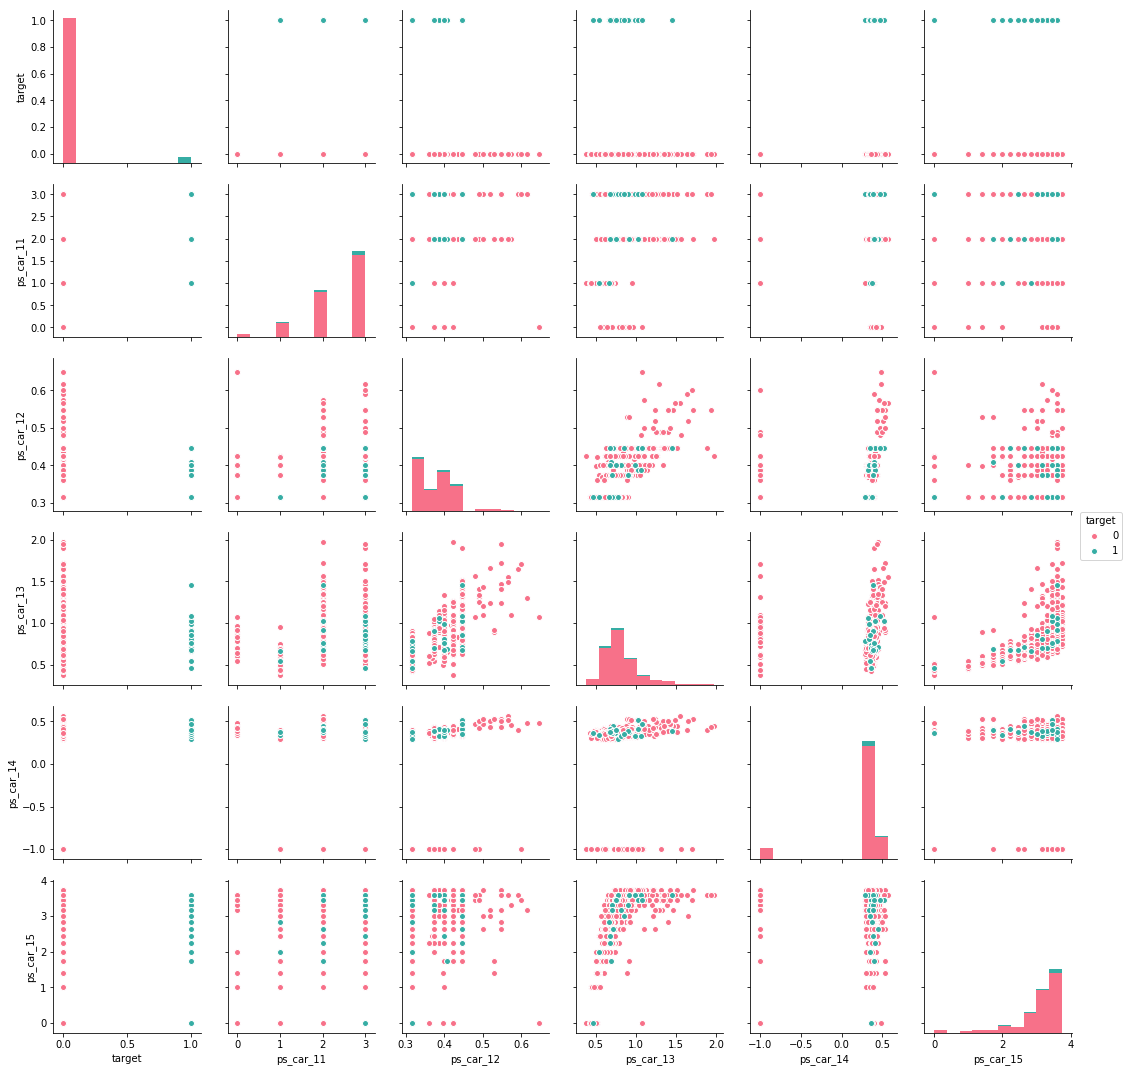

In [12]:
tmp = pd.concat([df['target'],df[car_con]],axis=1)
sns.pairplot(tmp[0:500],hue='target',palette="husl")

let's check how the target classes are distributd among the REG continuous features

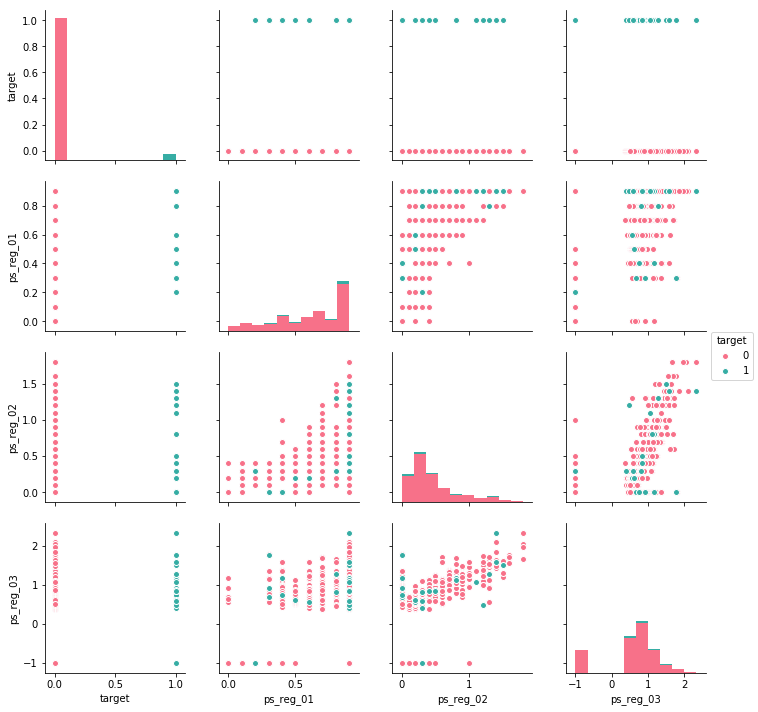

In [13]:
tmp = pd.concat([df['target'],df[reg_con]],axis=1)
sns.pairplot(tmp[0:500],hue='target',palette="husl")

let's check how the target classes are distributd among the IND continuous features

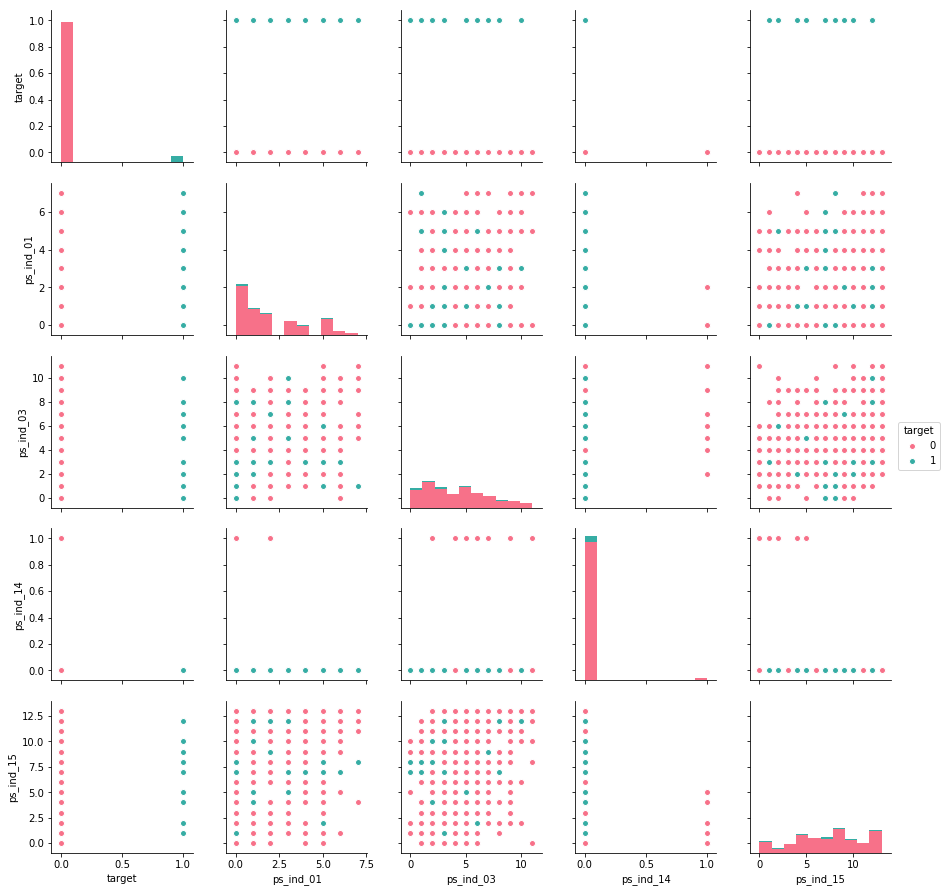

In [14]:
tmp = pd.concat([df['target'],df[ind_con]],axis=1)
sns.pairplot(tmp[0:500],hue='target',palette="husl")

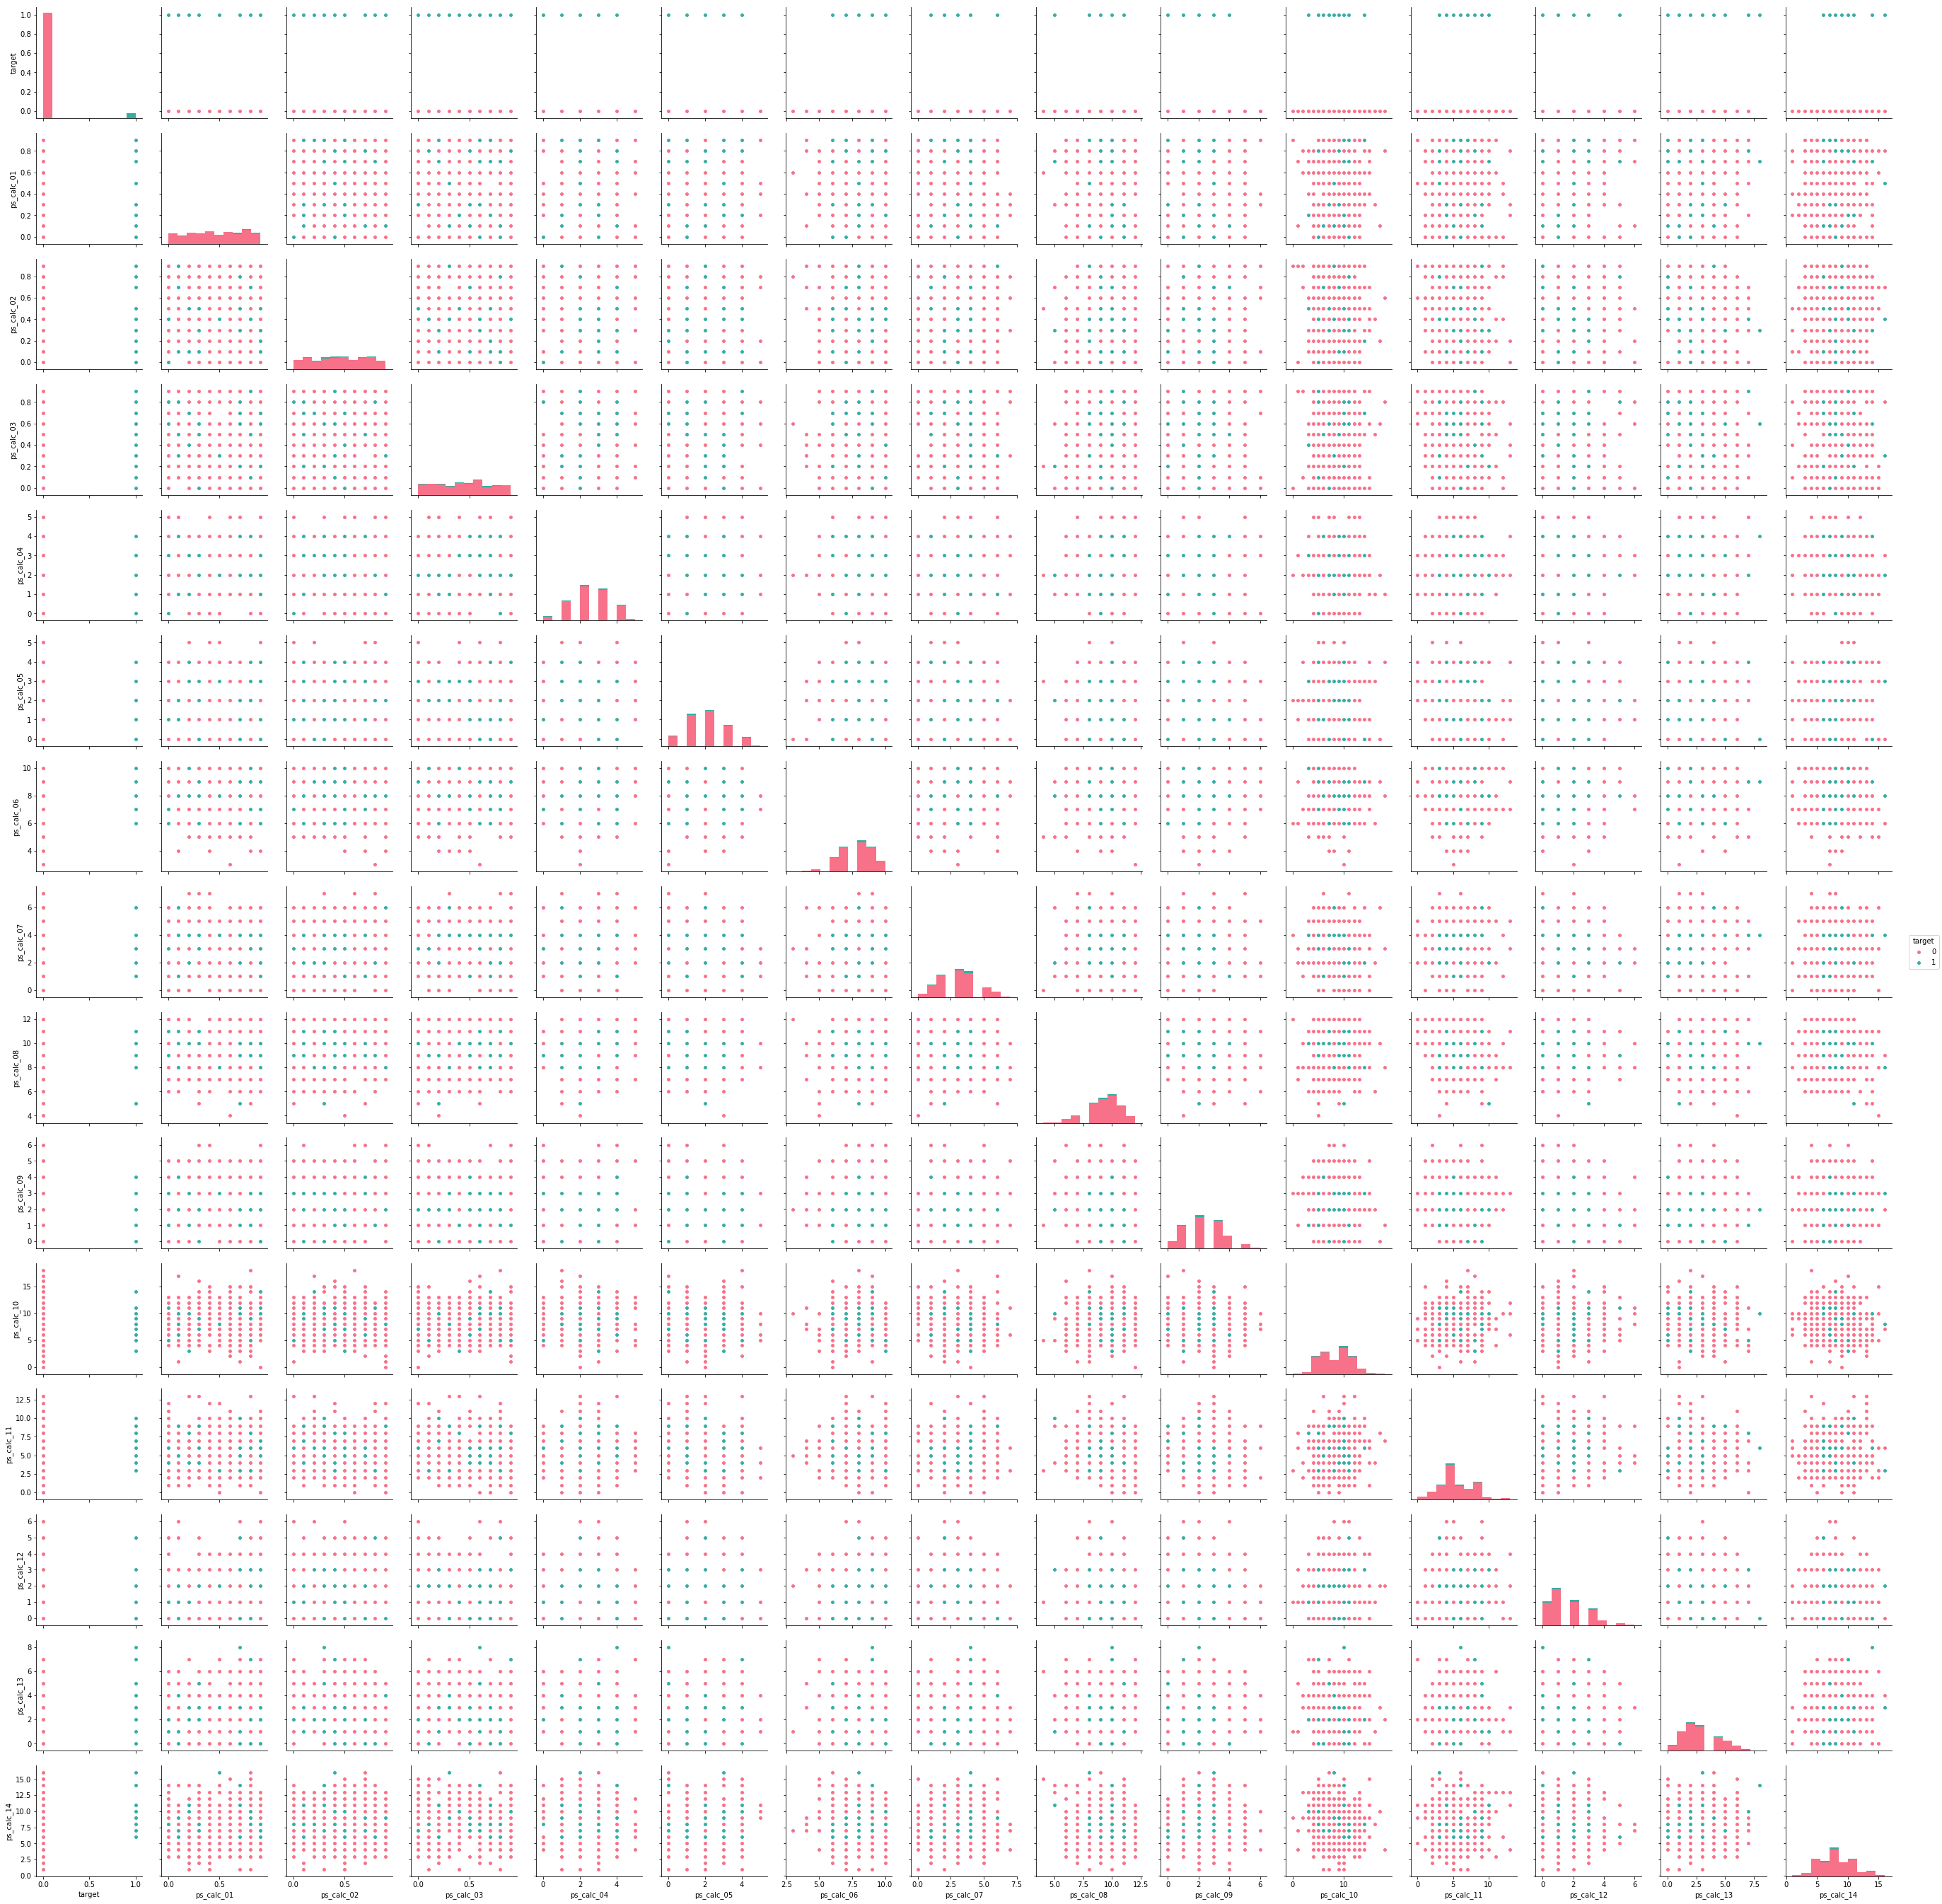

In [15]:
tmp = pd.concat([df['target'],df[calc_con]],axis=1)
sns.pairplot(tmp[0:500],hue='target',palette="husl")

#### Continuous Features Importance

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

clf = RandomForestClassifier(n_estimators = 50,random_state=0)
clf.fit(rdf[car_con],rdf['target'])
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(len(indices)):
    print (car_con[indices[i]],importances[indices[i]])

ps_car_13 0.712133195322
ps_car_14 0.145394074482
ps_car_15 0.0686606843641
ps_car_12 0.0476112726174
ps_car_11 0.0262007732152


In [17]:
clf = RandomForestClassifier(n_estimators = 50,random_state=0)
clf.fit(rdf[ind_con],rdf['target'])
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(len(indices)):
    print (ind_con[indices[i]],importances[indices[i]])

ps_ind_03 0.377267785128
ps_ind_15 0.333591830837
ps_ind_01 0.23925754954
ps_ind_14 0.0498828344949


In [18]:
clf = RandomForestClassifier(n_estimators = 50,random_state=0)
clf.fit(rdf[reg_con],rdf['target'])
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(len(indices)):
    print (reg_con[indices[i]],importances[indices[i]])

ps_reg_03 0.930096450565
ps_reg_02 0.0457586805136
ps_reg_01 0.0241448689211


In [19]:
clf = RandomForestClassifier(n_estimators = 50,random_state=0)
clf.fit(rdf[calc_con],rdf['target'])
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(len(indices)):
    print (calc_con[indices[i]],importances[indices[i]])

ps_calc_14 0.0909658873131
ps_calc_10 0.0863720738518
ps_calc_11 0.0840544808398
ps_calc_03 0.0815446566086
ps_calc_01 0.081518057633
ps_calc_02 0.0763235084871
ps_calc_13 0.072656935205
ps_calc_07 0.0677598106441
ps_calc_08 0.0666393294934
ps_calc_09 0.0624470523364
ps_calc_06 0.0614879617582
ps_calc_05 0.0599951649211
ps_calc_12 0.0551469861158
ps_calc_04 0.0530880947927


## Categorical

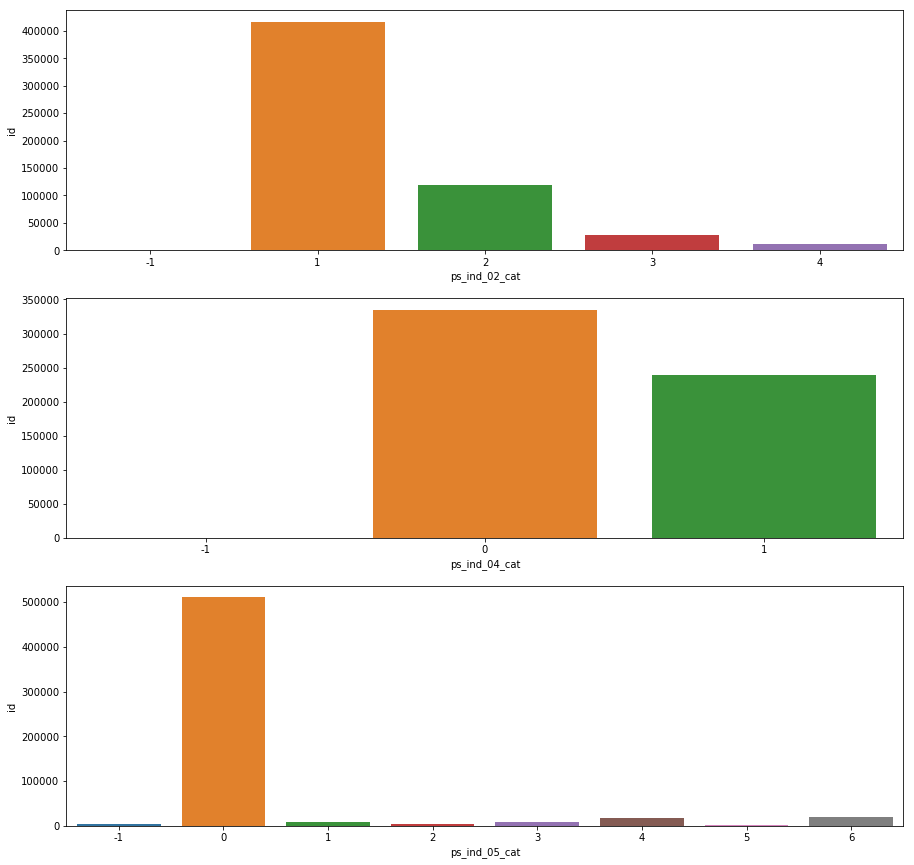

In [20]:
fig,axarray = plt.subplots(3,1,figsize=(15,15))
ind_cat_2_hist = df[df['target']==0].groupby(['ps_ind_02_cat'],as_index=False).count()
ind_cat_4_hist = df[df['target']==0].groupby(['ps_ind_04_cat'],as_index=False).count()
ind_cat_5_hist = df[df['target']==0].groupby(['ps_ind_05_cat'],as_index=False).count()
sns.barplot(x=ind_cat_2_hist['ps_ind_02_cat'],y=ind_cat_2_hist['id'],ax=axarray[0])
sns.barplot(x=ind_cat_4_hist['ps_ind_04_cat'],y=ind_cat_4_hist['id'],ax=axarray[1])
sns.barplot(x=ind_cat_5_hist['ps_ind_05_cat'],y=ind_cat_5_hist['id'],ax=axarray[2])


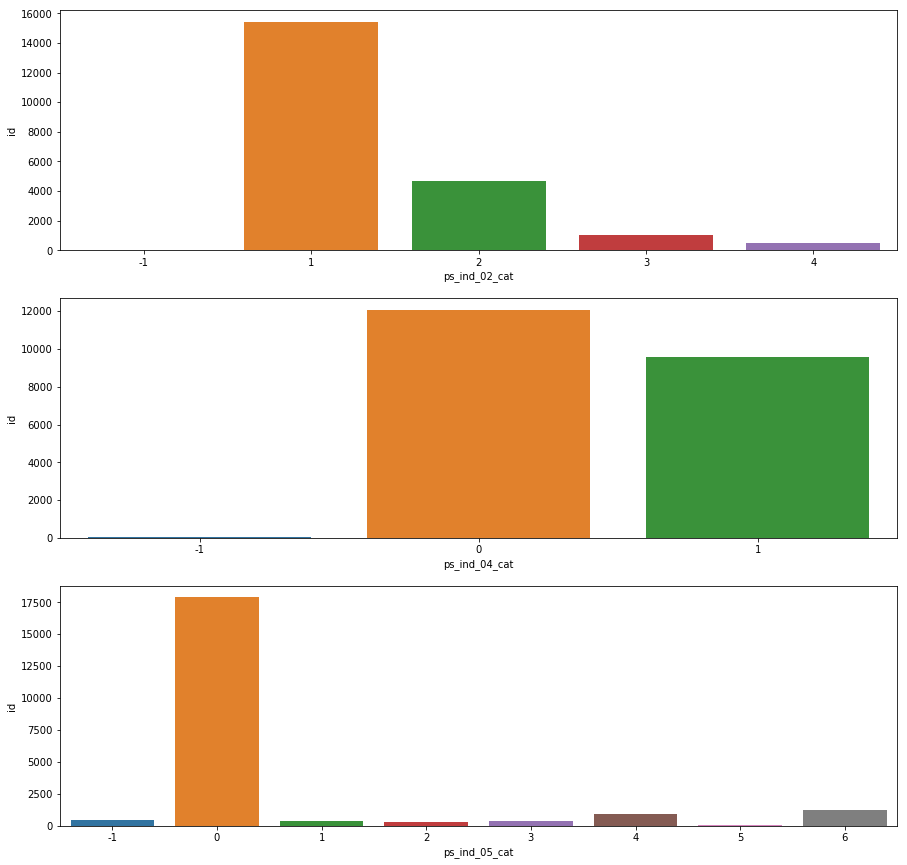

In [21]:
fig,axarray = plt.subplots(3,1,figsize=(15,15))
ind_cat_2_hist = df[df['target']==1].groupby(['ps_ind_02_cat'],as_index=False).count()
ind_cat_4_hist = df[df['target']==1].groupby(['ps_ind_04_cat'],as_index=False).count()
ind_cat_5_hist = df[df['target']==1].groupby(['ps_ind_05_cat'],as_index=False).count()
sns.barplot(x=ind_cat_2_hist['ps_ind_02_cat'],y=ind_cat_2_hist['id'],ax=axarray[0])
sns.barplot(x=ind_cat_4_hist['ps_ind_04_cat'],y=ind_cat_4_hist['id'],ax=axarray[1])
sns.barplot(x=ind_cat_5_hist['ps_ind_05_cat'],y=ind_cat_5_hist['id'],ax=axarray[2])

In [22]:
inddummies = pd.get_dummies(rdf['ps_ind_02_cat'],prefix="ind_02")
inddummies = pd.concat([inddummies,pd.get_dummies(rdf['ps_ind_04_cat'],prefix="ind_04")],axis=1)
inddummies = pd.concat([inddummies,pd.get_dummies(rdf['ps_ind_05_cat'],prefix="ind_05")],axis=1)

In [23]:
cardummies = pd.get_dummies(rdf['ps_car_01_cat'],prefix="car_01")
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_02_cat'],prefix="car_02")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_03_cat'],prefix="car_03")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_04_cat'],prefix="car_04")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_05_cat'],prefix="car_05")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_06_cat'],prefix="car_06")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_07_cat'],prefix="car_07")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_08_cat'],prefix="car_08")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_09_cat'],prefix="car_09")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_10_cat'],prefix="car_10")],axis=1)
cardummies = pd.concat([cardummies,pd.get_dummies(rdf['ps_car_11_cat'],prefix="car_11")],axis=1)


In [24]:
car_cat

['ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

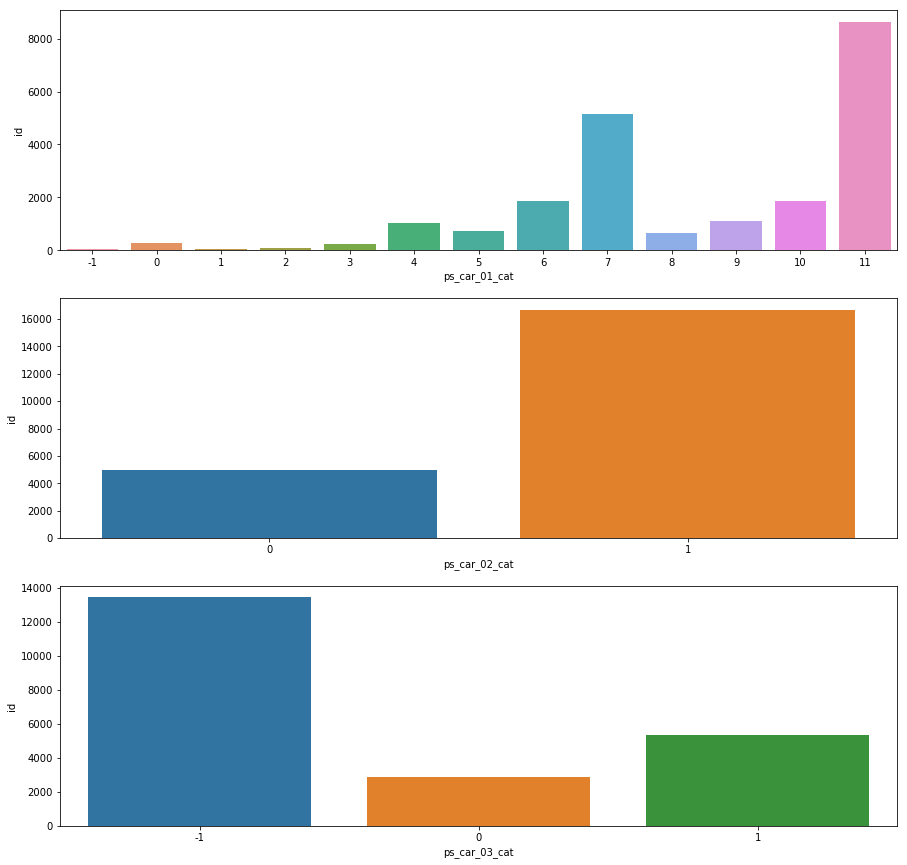

In [25]:
fig,axarray = plt.subplots(3,1,figsize=(15,15))
ind_car_1_hist = df[df['target']==1].groupby(['ps_car_01_cat'],as_index=False).count()
ind_car_2_hist = df[df['target']==1].groupby(['ps_car_02_cat'],as_index=False).count()
ind_car_3_hist = df[df['target']==1].groupby(['ps_car_03_cat'],as_index=False).count()
ind_car_1_hist = df[df['target']==1].groupby(['ps_car_01_cat'],as_index=False).count()
ind_car_2_hist = df[df['target']==1].groupby(['ps_car_02_cat'],as_index=False).count()
ind_car_3_hist = df[df['target']==1].groupby(['ps_car_03_cat'],as_index=False).count()



sns.barplot(x=ind_car_1_hist['ps_car_01_cat'],y=ind_car_1_hist['id'],ax=axarray[0])
sns.barplot(x=ind_car_2_hist['ps_car_02_cat'],y=ind_car_2_hist['id'],ax=axarray[1])
sns.barplot(x=ind_car_3_hist['ps_car_03_cat'],y=ind_car_3_hist['id'],ax=axarray[2])

Work in Progress...

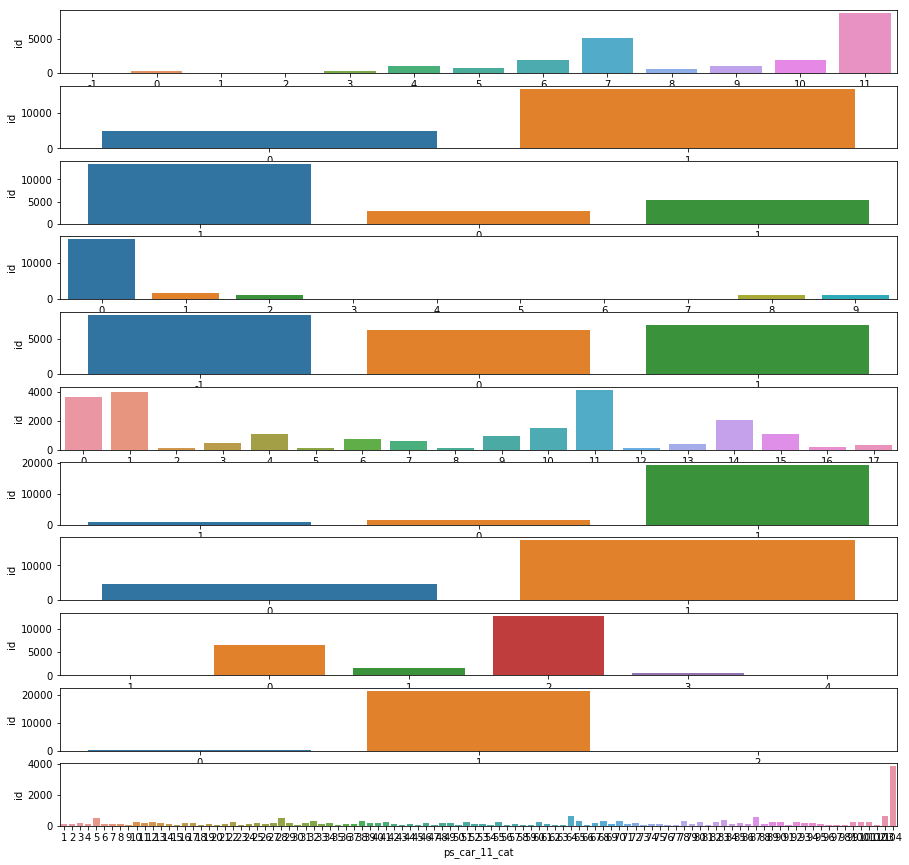

In [26]:
fig,axarray = plt.subplots(11,1,figsize=(15,15))
ind_car_1_hist = df[df['target']==1].groupby(['ps_car_01_cat'],as_index=False).count()
ind_car_2_hist = df[df['target']==1].groupby(['ps_car_02_cat'],as_index=False).count()
ind_car_3_hist = df[df['target']==1].groupby(['ps_car_03_cat'],as_index=False).count()
ind_car_4_hist = df[df['target']==1].groupby(['ps_car_04_cat'],as_index=False).count()
ind_car_5_hist = df[df['target']==1].groupby(['ps_car_05_cat'],as_index=False).count()
ind_car_6_hist = df[df['target']==1].groupby(['ps_car_06_cat'],as_index=False).count()
ind_car_7_hist = df[df['target']==1].groupby(['ps_car_07_cat'],as_index=False).count()
ind_car_8_hist = df[df['target']==1].groupby(['ps_car_08_cat'],as_index=False).count()
ind_car_9_hist = df[df['target']==1].groupby(['ps_car_09_cat'],as_index=False).count()
ind_car_10_hist = df[df['target']==1].groupby(['ps_car_10_cat'],as_index=False).count()
ind_car_11_hist = df[df['target']==1].groupby(['ps_car_11_cat'],as_index=False).count()

sns.barplot(x=ind_car_1_hist['ps_car_01_cat'],y=ind_car_1_hist['id'],ax=axarray[0])
sns.barplot(x=ind_car_2_hist['ps_car_02_cat'],y=ind_car_2_hist['id'],ax=axarray[1])
sns.barplot(x=ind_car_3_hist['ps_car_03_cat'],y=ind_car_3_hist['id'],ax=axarray[2])
sns.barplot(x=ind_car_4_hist['ps_car_04_cat'],y=ind_car_4_hist['id'],ax=axarray[3])
sns.barplot(x=ind_car_5_hist['ps_car_05_cat'],y=ind_car_5_hist['id'],ax=axarray[4])
sns.barplot(x=ind_car_6_hist['ps_car_06_cat'],y=ind_car_6_hist['id'],ax=axarray[5])
sns.barplot(x=ind_car_7_hist['ps_car_07_cat'],y=ind_car_7_hist['id'],ax=axarray[6])
sns.barplot(x=ind_car_8_hist['ps_car_08_cat'],y=ind_car_8_hist['id'],ax=axarray[7])
sns.barplot(x=ind_car_9_hist['ps_car_09_cat'],y=ind_car_9_hist['id'],ax=axarray[8])
sns.barplot(x=ind_car_10_hist['ps_car_10_cat'],y=ind_car_10_hist['id'],ax=axarray[9])
sns.barplot(x=ind_car_11_hist['ps_car_11_cat'],y=ind_car_11_hist['id'],ax=axarray[10])

work in progress